In [103]:
import torch
import numpy as np 
import pickle

In [104]:
dataPath = './data_train_lift.pkl'

In [105]:
with open(dataPath, 'rb') as f:
    data = pickle.load(f)

In [106]:
X = []
for i in data['joint_2d_1']:
    a = i.flatten()
    X.append(a)

In [107]:
X = np.array(X,dtype=np.float32)

In [108]:
Y = []
for i in data['joint_3d']:
    a = i.flatten()
    Y.append(a)

In [109]:
Y = np.array(Y,dtype=np.float32)

In [110]:
print(X.shape)
print(Y.shape)

(78047, 30)
(78047, 45)


In [111]:
dataset = []
for i in range(len(X)):
    dataset.append([X[i],Y[i]])

In [112]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [113]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, shuffle=False)

In [114]:
class ResidualBlock(torch.nn.Module):

    def __init__(self,input_size,hidden_layer,dropout):
        super(ResidualBlock, self).__init__()
        self.layer1 = torch.nn.Linear(input_size,hidden_layer)
        self.batch1 = torch.nn.BatchNorm1d(hidden_layer)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.drop1 = torch.nn.Dropout(p=dropout)
        self.layer2 = torch.nn.Linear(hidden_layer,hidden_layer)
        self.batch2 = torch.nn.BatchNorm1d(hidden_layer)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.drop2 = torch.nn.Dropout(p=dropout)

    def forward(self,X):
        residual =  X
        out = self.layer1(X)
        out = self.batch1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        out = self.layer2(out)
        out = self.batch2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        out += residual
        return (out)




In [115]:
class Network(torch.nn.Module):
    def __init__(self, n_blocks=2, hidden_layer=1024, dropout=0.1, output_nodes=15*3):
        super(Network, self).__init__()
        self.input = torch.nn.Linear(30,hidden_layer)
        self.l1 = ResidualBlock(hidden_layer,hidden_layer,dropout)
        self.l2 = ResidualBlock(hidden_layer,hidden_layer,dropout)
        self.final = torch.nn.Linear(hidden_layer,output_nodes)

    
    
    def forward(self, X):
        out = self.input(X)
        out = self.l1(out)
        out = self.l2(out)
        out = self.final(out)
        return (out)

In [116]:
def cal_mpjpe(p1, p2,avg):
    pose_1 = p1.clone().detach()
    pose_2 = p2.clone().detach()
    n_joints = 15
    batch_size = pose_1.shape[0]
    pose_1 = torch.reshape(pose_1,(batch_size,n_joints,3))
    pose_2 = torch.reshape(pose_2,(batch_size,n_joints,3))
    diff = pose_1-pose_2
    diff_sq = diff ** 2 
    dist_per_joint = torch.sqrt(torch.sum(diff_sq, axis=2))
    dist_per_sample = torch.mean(dist_per_joint, axis=1)
    if avg is True:
        dist_avg = torch.mean(dist_per_sample)
    else:
        dist_avg = dist_per_sample
    return dist_avg

In [117]:
model = Network(n_blocks=2, hidden_layer=1024, dropout=0.1, output_nodes=15*3)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
# enumerate epochs
for epoch in range(20):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = cal_mpjpe(yhat, targets,avg=True)
      
        loss.requires_grad = True
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

    l = 0 

    for i, (inputs, targets) in enumerate(train_dl):
        yhat = model(inputs)
        # calculate loss
        l += cal_mpjpe(yhat, targets,avg=True)
    
    l = l / len(train_dl)
    print(epoch, " ", loss)



0   tensor(1.7663, requires_grad=True)
1   tensor(1.7250, requires_grad=True)
2   tensor(1.7827, requires_grad=True)
3   tensor(1.7564, requires_grad=True)
4   tensor(1.7606, requires_grad=True)
5   tensor(1.7587, requires_grad=True)
6   tensor(1.7411, requires_grad=True)
7   tensor(1.7731, requires_grad=True)
8   tensor(1.7372, requires_grad=True)
9   tensor(1.7326, requires_grad=True)
10   tensor(1.7520, requires_grad=True)
11   tensor(1.7489, requires_grad=True)
12   tensor(1.7736, requires_grad=True)
13   tensor(1.7659, requires_grad=True)
14   tensor(1.7700, requires_grad=True)
15   tensor(1.7740, requires_grad=True)
16   tensor(1.7581, requires_grad=True)
17   tensor(1.7493, requires_grad=True)
18   tensor(1.6971, requires_grad=True)
19   tensor(1.7445, requires_grad=True)


In [5]:
import matplotlib.pyplot as plt 
normalised = [1.4687522649765015, 1.4691708087921143, 1.469057321548462, 1.468987226486206, 1.468649983406067, 1.4691277742385864, 1.4689656496047974, 1.4688280820846558, 1.469031572341919, 1.4688420295715332, 1.4691389799118042, 1.4688057899475098]
dropout = [1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273, 1.4705419540405273]
normalisation = [1.1653199195861816, 1.1653183698654175, 1.165327787399292, 1.1653363704681396, 1.1653448343276978, 1.165337085723877, 1.1653461456298828, 1.165339708328247, 1.1653311252593994, 1.1653382778167725, 1.165329098701477, 1.1653093099594116]
layers3 = [1.7168930768966675, 1.7166173458099365, 1.716627597808838, 1.7168755531311035, 1.7168128490447998, 1.716700792312622, 1.7168493270874023, 1.7169055938720703, 1.7167316675186157, 1.7172338962554932, 1.7171242237091064, 1.7163174152374268]

In [6]:
e = [i for i in range(1,13)]


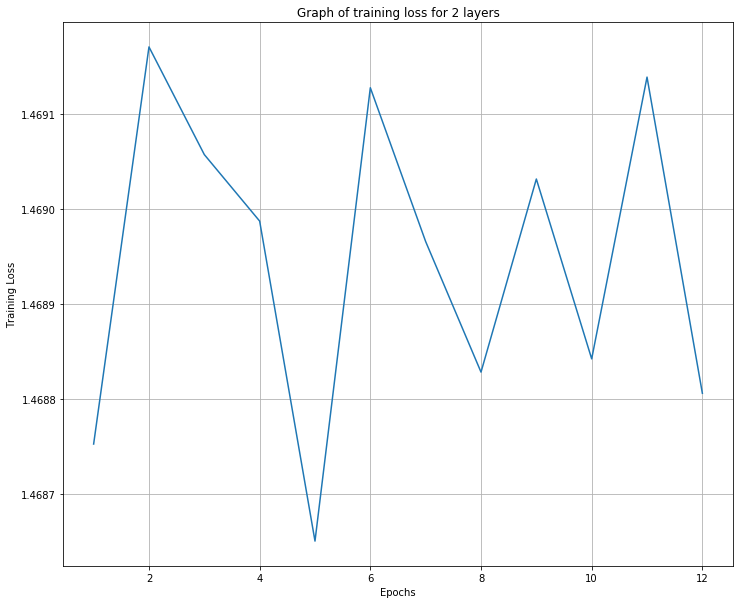

In [15]:

plt.figure(figsize=(12,10))
plt.plot(e,normalised)
plt.grid()
plt.title("Graph of training loss for 2 layers")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.savefig('2layes.png')


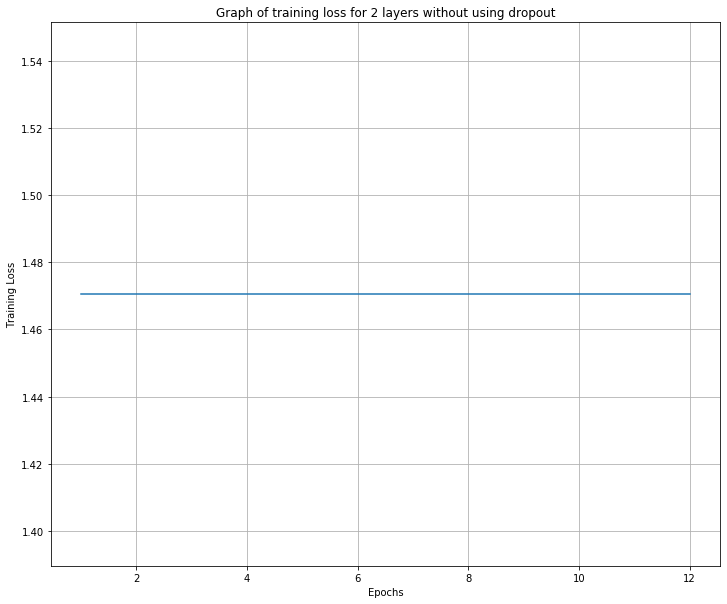

In [16]:
plt.figure(figsize=(12,10))
plt.plot(e,dropout)
plt.grid()
plt.title("Graph of training loss for 2 layers without using dropout")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.savefig('Dropout.png')


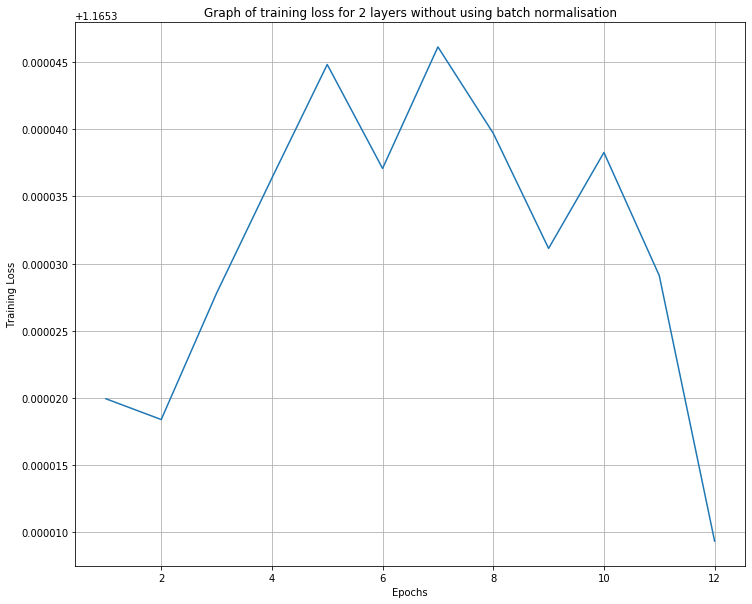

In [17]:
plt.figure(figsize=(12,10))
plt.plot(e,normalisation)
plt.grid()
plt.title("Graph of training loss for 2 layers without using batch normalisation")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.savefig('BatchNormalisation.png')

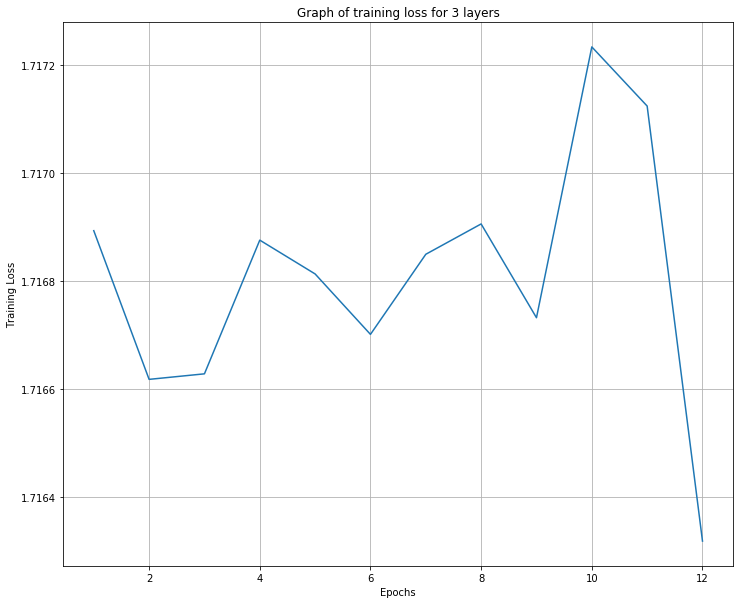

In [18]:
plt.figure(figsize=(12,10))
plt.plot(e,layers3)
plt.grid()
plt.title("Graph of training loss for 3 layers")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.savefig('3Layers.png')